# Credit Risk

Credit Risk is the possibility of a loss resulting from a borrower's failure to repay a
loan or meet a contractual obligation. The primary goal of a credit risk assessment is to find out whether potential borrowers are creditworthy and have the means to repay their debts so that credit risk or loss can be minimized and the loan is granted to only creditworthy applicants.

If the borrower shows an acceptable level of default risk, then their loan application can be approved upon agreed terms. 

This project involves understanding financial terminologies attached to credit risk and building a classification model for default prediction with Pycaret. Hyperparameter Optimization is done using also the Pycaret library.

# Libraries

In [1]:
#%pip install shap==0.40.0
#%pip install hyperopt==0.2.7

In [2]:
import pandas as pd
import inflection
import missingno as msno
import seaborn as sns
import numpy as np
import re

import scipy.stats as stats
from scipy import stats as ss
from scipy.stats import chi2_contingency
from matplotlib import pyplot as plt
from IPython.display import Image
from utils import *

import ipywidgets as widgets
from ipywidgets import interact
import plotly.express as px

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, CDSView, IndexFilter
from bokeh.layouts import row, column
from scipy.stats import gaussian_kde
from bokeh.models import RangeSlider

from sklearn import preprocessing as pp
from imblearn import under_sampling as us
from imblearn import over_sampling as oversamp
from pandas_profiling import ProfileReport
from category_encoders import TargetEncoder
from sklearn import model_selection as ms
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec
from sklearn.cluster import DBSCAN

import random
from sklearn import metrics as m
from sklearn.metrics import classification_report, cohen_kappa_score, roc_curve, brier_score_loss
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, recall_score, f1_score, roc_auc_score, precision_score, roc_curve
#from sklearn.metrics import plot_precision_recall_curve

from scikitplot import metrics as mt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
import category_encoders

from datetime import datetime, timedelta
import pickle

# Loadind Data

In [3]:
pwd

'/Users/lucasquemelli/Documents/repos/credit_default_risk_prediction'

In [4]:
data = pd.read_csv("/Users/lucasquemelli/Documents/repos/credit_default_risk_prediction/credit_risk_data.csv")
data.head()

Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.


,User_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,gender,married,dependents,...,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
0,7013527,Salaried,B,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGAZSEWdkcndwkcnCCM,1-2,125000.000,Female,Yes,4,...,852.690,0,0,90,90,90,90,90,90,202203
1,7014291,Self - Employeed,D,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNCSEWdkcndwkcnCCM,10+,61000.000,Female,No,1,...,4912.530,0,0,0,0,0,0,0,0,202203
2,7014327,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNYSEWdkcndwkcnCCM,5-10,100000.000,Other,NaN,3,...,3310.680,0,90,90,90,90,90,90,90,202205
3,7014304,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,2-3,30000.000,Male,NaN,1,...,1459.760,0,0,0,0,0,0,0,0,202203
4,7031995,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,10+,65000.000,Male,NaN,3,...,1793.000,0,0,0,0,0,0,0,0,202203


In [5]:
cols_old = data.columns

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

data.columns = cols_new

In [6]:
data.columns

Index(['user_id', 'employment_type', 'tier_of_employment', 'industry', 'role',
       'work_experience', 'total_income', 'gender', 'married', 'dependents',
       'home_type', 'pincode', 'has_social_profile', 'is_verified',
       'delinq_2yrs', 'total_payement', 'received_principal',
       'interest_received', 'number_of_loans', 'emi_1_dpd', 'emi_2_dpd',
       'emi_3_dpd', 'emi_4_dpd', 'emi_5_dpd', 'emi_6_dpd', 'max_dpd',
       'yearmo'],
      dtype='object')

# Duplication Test

Since this analysis should be at user level, would it be affordable to have more rows than userids? 

In [7]:
data["user_id"].nunique()

133752

In [8]:
data.shape[0]

143727

Notice below that some users appears more than once. Some of them appears 16 times. Let's check it out. 

In [9]:
data["user_id"].value_counts()

3166625     16
2803481     16
2789468     16
3440082     16
3062454     16
            ..
2814679      1
2819122      1
2818821      1
2819179      1
56122051     1
Name: user_id, Length: 133752, dtype: int64

In [10]:
data[data["user_id"] == 3166625]

,user_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,gender,married,dependents,...,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
36527,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.000,Female,Yes,3,...,3355.560,0,90,90,90,90,90,90,90,202201
36528,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.000,Female,Yes,3,...,550.890,0,0,0,0,0,0,0,0,202203
36529,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.000,Female,Yes,2,...,3355.560,0,90,90,90,90,90,90,90,202203
36530,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.000,Female,Yes,2,...,550.890,0,0,0,0,0,0,0,0,202203
36531,3166625,Salaried,D,0,KHMbckjadbckIFGMDSEWdkcndwkcnCCM,0,115000.000,Female,Yes,3,...,3355.560,0,90,90,90,90,90,90,90,202205
36532,3166625,Salaried,D,0,KHMbckjadbckIFGMDSEWdkcndwkcnCCM,0,115000.000,Female,Yes,3,...,550.890,0,0,0,0,0,0,0,0,202205
36533,3166625,Salaried,D,0,KHMbckjadbckIFGMDSEWdkcndwkcnCCM,0,115000.000,Female,Yes,2,...,3355.560,0,90,90,90,90,90,90,90,202202
36534,3166625,Salaried,D,0,KHMbckjadbckIFGMDSEWdkcndwkcnCCM,0,115000.000,Female,Yes,2,...,550.890,0,0,0,0,0,0,0,0,202205
36535,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.000,Female,Yes,3,...,3355.560,0,0,90,90,90,90,90,90,202201
36536,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.000,Female,Yes,3,...,550.890,0,0,0,0,0,0,0,0,202205


In [11]:
data.iloc[:, 0:15]

,user_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,gender,married,dependents,home_type,pincode,has_social_profile,is_verified,delinq_2yrs
0,7013527,Salaried,B,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGAZSEWdkcndwkcnCCM,1-2,125000.000,Female,Yes,4,rent,XX852X,No,NaN,0
1,7014291,Self - Employeed,D,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNCSEWdkcndwkcnCCM,10+,61000.000,Female,No,1,mortgage,XX286X,NaN,Source Verified,0
2,7014327,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNYSEWdkcndwkcnCCM,5-10,100000.000,Other,NaN,3,own,XX113X,No,NaN,0
3,7014304,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,2-3,30000.000,Male,NaN,1,rent,XX941X,Yes,NaN,0
4,7031995,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,10+,65000.000,Male,NaN,3,rent,XX913X,No,Verified,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143722,55993166,NaN,NaN,0,KHMbckjadbckIFGTNSEWdkcndwkcnCCM,0,100000.000,Female,No,2,mortgage,XX374X,NaN,Source Verified,1
143723,56263229,NaN,NaN,0,KHMbckjadbckIFGOHSEWdkcndwkcnCCM,0,27000.000,Male,Yes,3,rent,XX436X,No,Source Verified,0
143724,55992716,NaN,NaN,0,KHMbckjadbckIFGCASEWdkcndwkcnCCM,0,53000.000,Female,Yes,2,rent,XX908X,NaN,NaN,0
143725,56363313,NaN,NaN,0,KHMbckjadbckIFGVASEWdkcndwkcnCCM,0,75400.000,Other,No,0,mortgage,XX229X,NaN,Source Verified,0


In [12]:
data.iloc[:, 15:30]

,total_payement,received_principal,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
0,1824.150,971.460,852.690,0,0,90,90,90,90,90,90,202203
1,22912.533,18000.000,4912.530,0,0,0,0,0,0,0,0,202203
2,7800.440,4489.760,3310.680,0,90,90,90,90,90,90,90,202205
3,6672.050,5212.290,1459.760,0,0,0,0,0,0,0,0,202203
4,11793.001,10000.000,1793.000,0,0,0,0,0,0,0,0,202203
...,...,...,...,...,...,...,...,...,...,...,...,...
143722,12842.400,7193.830,5648.570,0,0,0,0,30,0,0,30,202205
143723,839.200,581.670,257.530,0,0,0,0,0,0,0,0,202203
143724,6085.800,2434.490,3651.310,0,0,0,0,0,0,0,0,202204
143725,4080.640,3286.820,793.820,0,0,0,0,0,0,30,30,202202


# Deduplication

Let's consider for deduplication:

1. The most recent updated date in our dataset for every user.
2. The smallest total income. 

In [13]:
# sort the dataframe by 'yearmo' in descending order
data.sort_values(by=['yearmo', 'total_income'], ascending=[False, True], inplace=True)

# drop duplicates based on 'user_id' while keeping the first occurence (maximum 'yearmo')
data = data.drop_duplicates(subset='user_id', keep='first')

# reset the index of the new dataframe
data.reset_index(drop=True, inplace=True)

In [14]:
data["user_id"].nunique()

133752

In [15]:
data.shape[0]

133752

In [16]:
data[data["user_id"] == 3166625]

,user_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,gender,married,dependents,...,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
6922,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.000,Female,Yes,3,...,550.890,0,0,0,0,0,0,0,0,202205


# Helper Functions

In [17]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y).values
    n = confusion_matrix.sum()
    r,k = confusion_matrix.shape
   
    chi2 = chi2_contingency(confusion_matrix)[0]
    phi2 = chi2/n
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
   
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# 1. Data Description

- For EMI: DPD equals to 0 is the number of days between 0 and 29. 
- 

In [18]:
df1 = data.copy()


| Columns            | Description                                           |
|--------------------|-------------------------------------------------------|
| User_id            | User Identifier                                       |
| employment_type    | Employment Type (Salaried, Self-Employed)             |
| tier_of_employment | Tier of Employment (According to company performance) |
| industry           | Industry of Employer                                  |
| role               | Role of User in company                               |
| work_experience    | Total Work Experience                                 |
| total_income       | Total Income of customer                              |
| gender             | Gender of Customer                                    |
| married            | Single / Married / Divorced / Widowed etc.            |
| dependents         | No. of dependents on user                             |
| home_type          | Rented / Owned etc.                                   |
| pincode            | Middle 3 digit of Pincode                             |
| has_social_profile | Has FB/Twitter or any other social profile            |
| is_verified        | Is Social Profile Verified                            |
| delinq_2yrs        | Number of loan delinquencies in last 2 years          |
| total_payement     | Total Payment made towards loan in last 2 years       |
| received_principal | Total Principal paid towards loan in last 2 years     |
| interest_received  | Total Interest Received towards loan in last 2 years  |
| number_of_loans    | Number of Loans in last 2 years                       |
| emi_1_dpd          | DPD in repayment of 1st EMI (0, 30+, 60+, 90+)        |
| emi_2_dpd          | DPD in repayment of 2nd EMI (0, 30+, 60+, 90+)        |
| emi_3_dpd          | DPD in repayment of 3rd EMI (0, 30+, 60+, 90+)        |
| emi_4_dpd          | DPD in repayment of 4th EMI (0, 30+, 60+, 90+)        |
| emi_5_dpd          | DPD in repayment of 5th EMI (0, 30+, 60+, 90+)        |
| emi_6_dpd          | DPD in repayment of 6th EMI (0, 30+, 60+, 90+)        |
| max_dpd            | Maximum DPD (0, 30+, 60+, 90+) attained               |
| yearmo             | Year and month of loan application (YYYYMM format)    |



## Action Items

- According to yearmo, split data in Train, Validation, Hold Out.
- DPD Roll Rate Analysis and Window Roll Rate Analysis for defining label (default = dpd X in first Y months, Define X & Y)

## 1.1. Data Dimensions

In [19]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 133752
Number of cols: 27


## 1.2. Data Types

In [20]:
df1.dtypes

user_id                 int64
employment_type        object
tier_of_employment     object
industry               object
role                   object
work_experience        object
total_income          float64
gender                 object
married                object
dependents              int64
home_type              object
pincode                object
has_social_profile     object
is_verified            object
delinq_2yrs             int64
total_payement        float64
received_principal    float64
interest_received     float64
number_of_loans         int64
emi_1_dpd               int64
emi_2_dpd               int64
emi_3_dpd               int64
emi_4_dpd               int64
emi_5_dpd               int64
emi_6_dpd               int64
max_dpd                 int64
yearmo                  int64
dtype: object

# 1.3. Data Conversion

In [21]:
df1['yearmo'] = df1['yearmo'].astype(str)  # Garante que 'yearmo' seja uma string
df1['yearmo'] = df1['yearmo'].apply(lambda x: f"{x[:4]}-{x[4:]}")
df1['yearmo'] = pd.to_datetime(df1['yearmo'], format='%Y-%m')

In [22]:
df1.dtypes

user_id                        int64
employment_type               object
tier_of_employment            object
industry                      object
role                          object
work_experience               object
total_income                 float64
gender                        object
married                       object
dependents                     int64
home_type                     object
pincode                       object
has_social_profile            object
is_verified                   object
delinq_2yrs                    int64
total_payement               float64
received_principal           float64
interest_received            float64
number_of_loans                int64
emi_1_dpd                      int64
emi_2_dpd                      int64
emi_3_dpd                      int64
emi_4_dpd                      int64
emi_5_dpd                      int64
emi_6_dpd                      int64
max_dpd                        int64
yearmo                datetime64[ns]
d

## 1.4. Na Check

In [23]:
df1.isna().sum()

user_id                   0
employment_type       79334
tier_of_employment    79334
industry                  4
role                      0
work_experience           4
total_income              0
gender                    0
married               44856
dependents                0
home_type                 0
pincode                   0
has_social_profile    44627
is_verified           33358
delinq_2yrs               0
total_payement            0
received_principal        0
interest_received         0
number_of_loans           0
emi_1_dpd                 0
emi_2_dpd                 0
emi_3_dpd                 0
emi_4_dpd                 0
emi_5_dpd                 0
emi_6_dpd                 0
max_dpd                   0
yearmo                    0
dtype: int64

In [24]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df1.isna().sum()/len(df1)

user_id              0.00
employment_type      0.59
tier_of_employment   0.59
industry             0.00
role                 0.00
work_experience      0.00
total_income         0.00
gender               0.00
married              0.34
dependents           0.00
home_type            0.00
pincode              0.00
has_social_profile   0.33
is_verified          0.25
delinq_2yrs          0.00
total_payement       0.00
received_principal   0.00
interest_received    0.00
number_of_loans      0.00
emi_1_dpd            0.00
emi_2_dpd            0.00
emi_3_dpd            0.00
emi_4_dpd            0.00
emi_5_dpd            0.00
emi_6_dpd            0.00
max_dpd              0.00
yearmo               0.00
dtype: float64

In [25]:
df1.dtypes

user_id                        int64
employment_type               object
tier_of_employment            object
industry                      object
role                          object
work_experience               object
total_income                 float64
gender                        object
married                       object
dependents                     int64
home_type                     object
pincode                       object
has_social_profile            object
is_verified                   object
delinq_2yrs                    int64
total_payement               float64
received_principal           float64
interest_received            float64
number_of_loans                int64
emi_1_dpd                      int64
emi_2_dpd                      int64
emi_3_dpd                      int64
emi_4_dpd                      int64
emi_5_dpd                      int64
emi_6_dpd                      int64
max_dpd                        int64
yearmo                datetime64[ns]
d

In [26]:
df1["employment_type"] = df1["employment_type"].fillna("SI")

df1["tier_of_employment"] = df1["tier_of_employment"].fillna("SI")

df1["industry"] = df1["industry"].fillna("SI")

df1["work_experience"] = df1["work_experience"].fillna("SI")

df1["married"] = df1["married"].fillna("SI")

df1["has_social_profile"] = df1["has_social_profile"].fillna("SI")

df1["is_verified"] = df1["is_verified"].fillna("SI")

In [27]:
df1.isna().sum()

user_id               0
employment_type       0
tier_of_employment    0
industry              0
role                  0
work_experience       0
total_income          0
gender                0
married               0
dependents            0
home_type             0
pincode               0
has_social_profile    0
is_verified           0
delinq_2yrs           0
total_payement        0
received_principal    0
interest_received     0
number_of_loans       0
emi_1_dpd             0
emi_2_dpd             0
emi_3_dpd             0
emi_4_dpd             0
emi_5_dpd             0
emi_6_dpd             0
max_dpd               0
yearmo                0
dtype: int64

## 1.6. Descriptive Statistics

In [28]:
num_attributes = df1.drop(columns=["user_id"]).select_dtypes(include=['int32', 'int64', 'float32', 'float64'])
cat_attributes = df1.select_dtypes(include=['object', 'category'])

### 1.6.1. Numerical Attributes

In [29]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,total_income,4000.000,7141778.000,7137778.000,72538.108,62000.000,56122.189,28.837,2791.391
1,dependents,0.000,4.000,4.000,2.002,2.000,1.414,-0.005,-1.300
2,delinq_2yrs,0.000,22.000,22.000,0.284,0.000,0.800,5.421,52.951
3,total_payement,0.000,57777.580,57777.580,10686.194,8046.045,8541.111,1.603,2.748
4,received_principal,0.000,35000.010,35000.010,8273.808,5860.050,7183.243,1.559,2.327
5,interest_received,0.000,24205.620,24205.620,2334.677,1626.310,2416.865,2.848,11.644
6,number_of_loans,0.000,5.000,5.000,0.006,0.000,0.099,22.902,635.940
7,emi_1_dpd,0.000,90.000,90.000,7.700,0.000,23.763,3.023,7.501
8,emi_2_dpd,0.000,90.000,90.000,8.301,0.000,24.595,2.842,6.405
9,emi_3_dpd,0.000,90.000,90.000,8.325,0.000,24.744,2.866,6.519


- The maximum value of DPD is 90 days.
- It seems the majority of users have lower total income, since we found a high standard deviation and positive skew.
- There is no variable with zero variance, but number of loans have standard deviation equals to 0.099. It is almost zero. It may suggest this variable may not be representative - no information to the model.

Let's look at the continuous features in order to perform an analysis. 

#### Total income

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


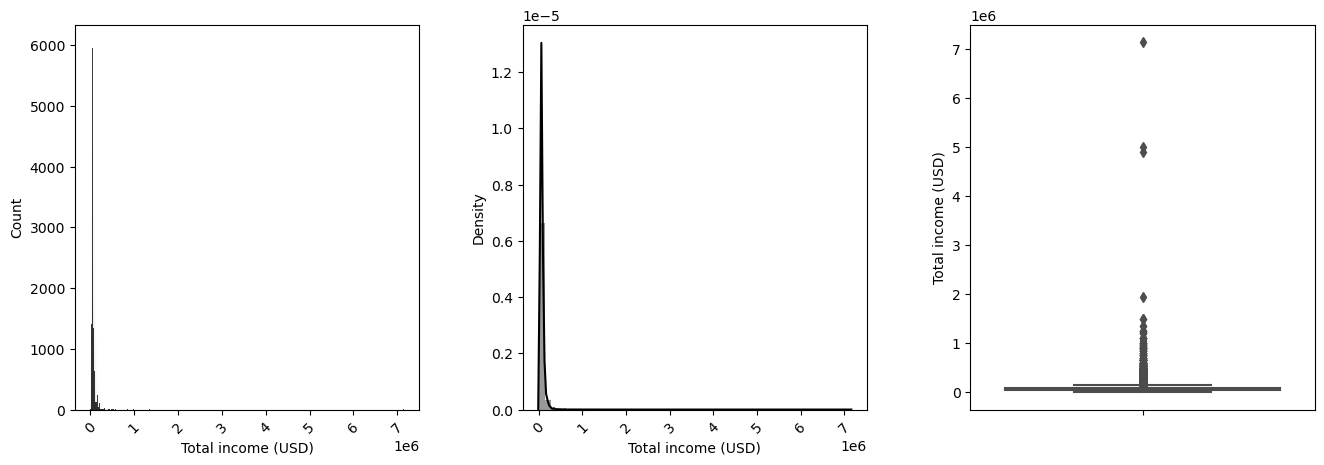

In [30]:
aux = num_attributes.copy()

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["total_income"], color="black")
plt.xlabel("Total income (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["total_income"], color="black")
plt.xlabel("Total income (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='total_income',data=aux, color="gray")
plt.ylabel("Total income (USD)")

plt.subplots_adjust(wspace = 0.30);

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


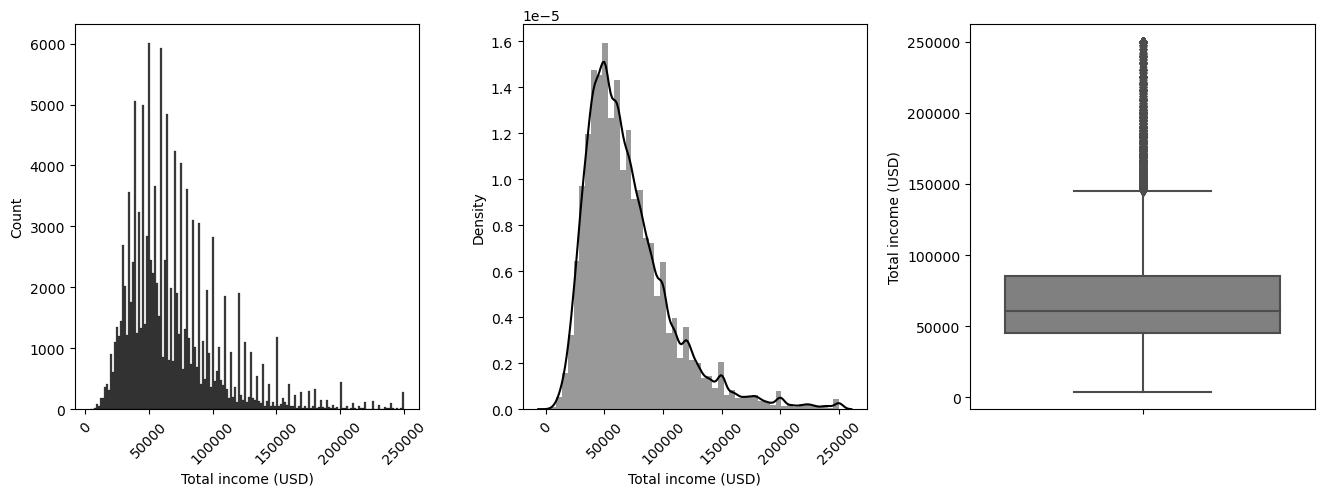

In [31]:
aux = num_attributes.copy()
aux = aux[aux["total_income"] <= 250000]

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["total_income"], color="black")
plt.xlabel("Total income (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["total_income"], color="black")
plt.xlabel("Total income (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='total_income',data=aux, color="gray")
plt.ylabel("Total income (USD)")

plt.subplots_adjust(wspace = 0.30);

In [32]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["total_income"]).describe().T

,count,mean,std,min,25%,50%,75%,max
total_income,132675.00,69857.66,36860.45,4000.00,45000.00,61000.00,85000.00,250000.00


- Since we have high value for skew and a high value for kurtosis, we may assume there are outliers for total income.
- Therefore, median is more representative than mean.
- Median is around 61000 USD. 
- A value lower than 250000 USD should be used as upper limit to remove outliers.

#### Total payment

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


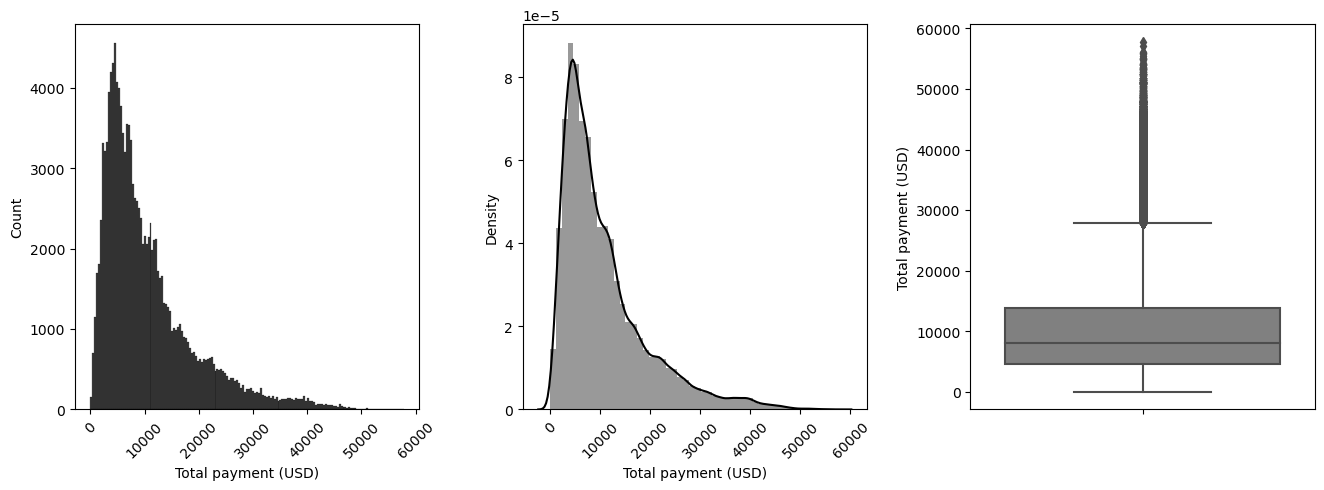

In [33]:
aux = num_attributes.copy()

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["total_payement"], color="black")
plt.xlabel("Total payment (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["total_payement"], color="black")
plt.xlabel("Total payment (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='total_payement',data=aux, color="gray")
plt.ylabel("Total payment (USD)")

plt.subplots_adjust(wspace = 0.30);

In [34]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["total_payement"]).describe().T

,count,mean,std,min,25%,50%,75%,max
total_payement,133752.00,10686.19,8541.14,0.00,4620.92,8046.05,13921.03,57777.58


- We can see some outliers in the distribution chart.
- We may assume median is proper than mean.
- Median is around 8000 USD.

#### Received principal

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


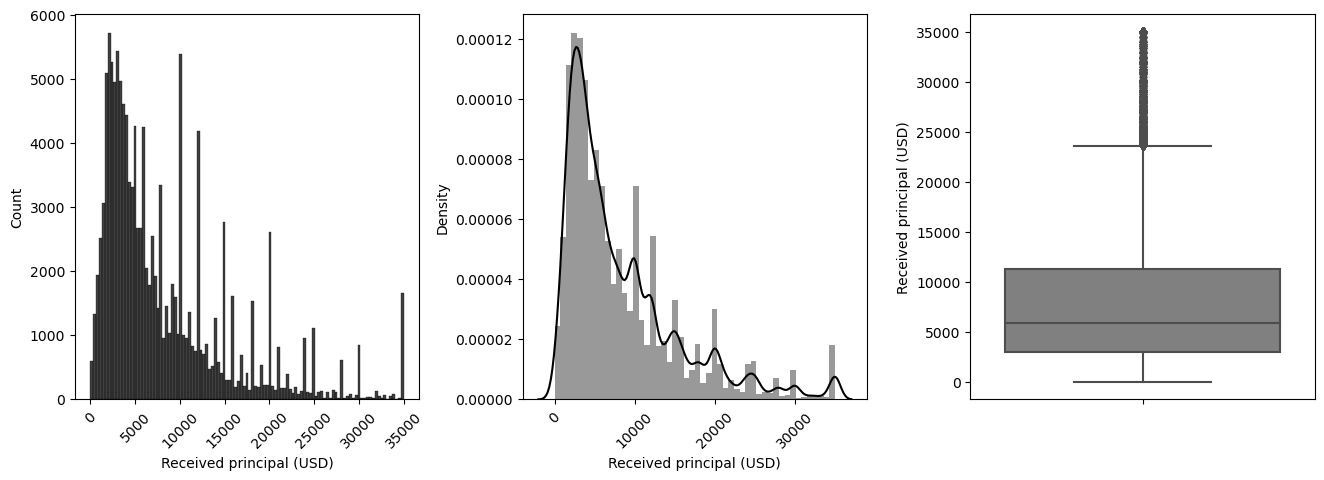

In [35]:
aux = num_attributes.copy()

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["received_principal"], color="black")
plt.xlabel("Received principal (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["received_principal"], color="black")
plt.xlabel("Received principal (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='received_principal',data=aux, color="gray")
plt.ylabel("Received principal (USD)")

plt.subplots_adjust(wspace = 0.30);

In [36]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["received_principal"]).describe().T

,count,mean,std,min,25%,50%,75%,max
received_principal,133752.00,8273.81,7183.27,0.00,3044.25,5860.05,11285.53,35000.01


- We may see some outliers.
- Median is proper.
- Median is around 5800 USD.

#### Interest received

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


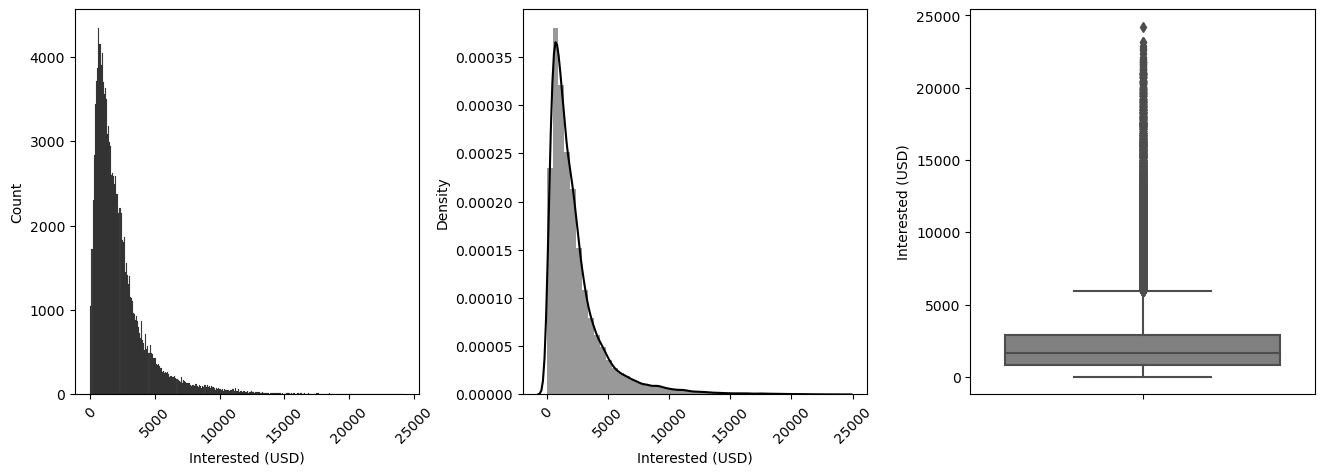

In [37]:
aux = num_attributes.copy()

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["interest_received"], color="black")
plt.xlabel("Interested (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["interest_received"], color="black")
plt.xlabel("Interested (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='interest_received',data=aux, color="gray")
plt.ylabel("Interested (USD)")

plt.subplots_adjust(wspace = 0.30);

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


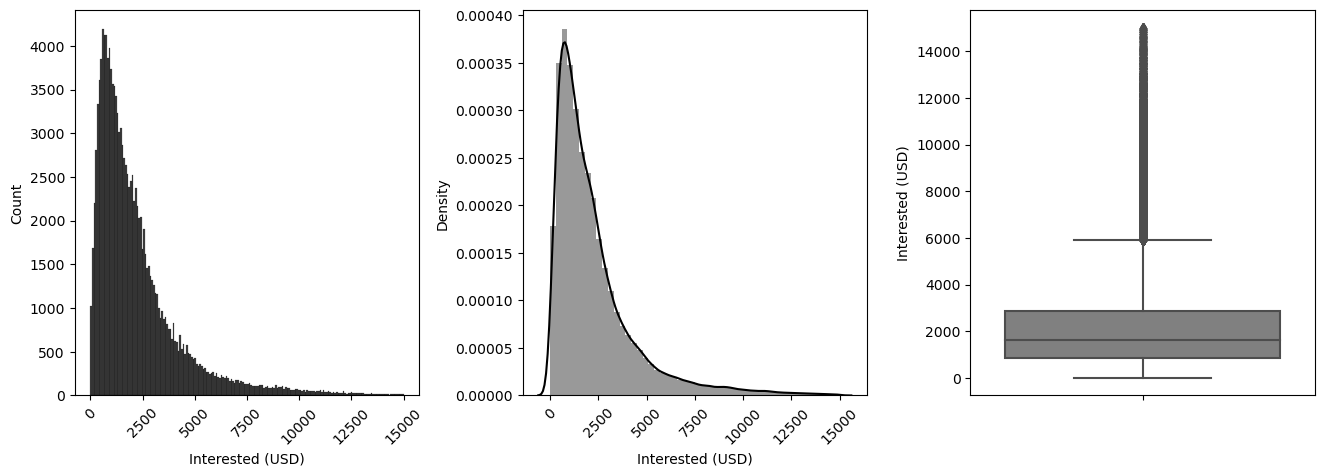

In [38]:
aux = num_attributes.copy()
aux = aux[aux["interest_received"] < 15000]

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["interest_received"], color="black")
plt.xlabel("Interested (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["interest_received"], color="black")
plt.xlabel("Interested (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='interest_received',data=aux, color="gray")
plt.ylabel("Interested (USD)")

plt.subplots_adjust(wspace = 0.30);

In [39]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["interest_received"]).describe().T

,count,mean,std,min,25%,50%,75%,max
interest_received,133089.00,2258.06,2160.46,0.00,835.54,1614.72,2860.08,14999.14


- Median around 1600 USD.
- Outliers above 15000.

### 1.6.2. Correlation Matrix

We use it in order to evaluate variables which are highly correlated. The objective is to exclude one of them. 

#### Pearson Correlation Coefficient

Pearson's correlation coefficient is used for linear correlation between variables.

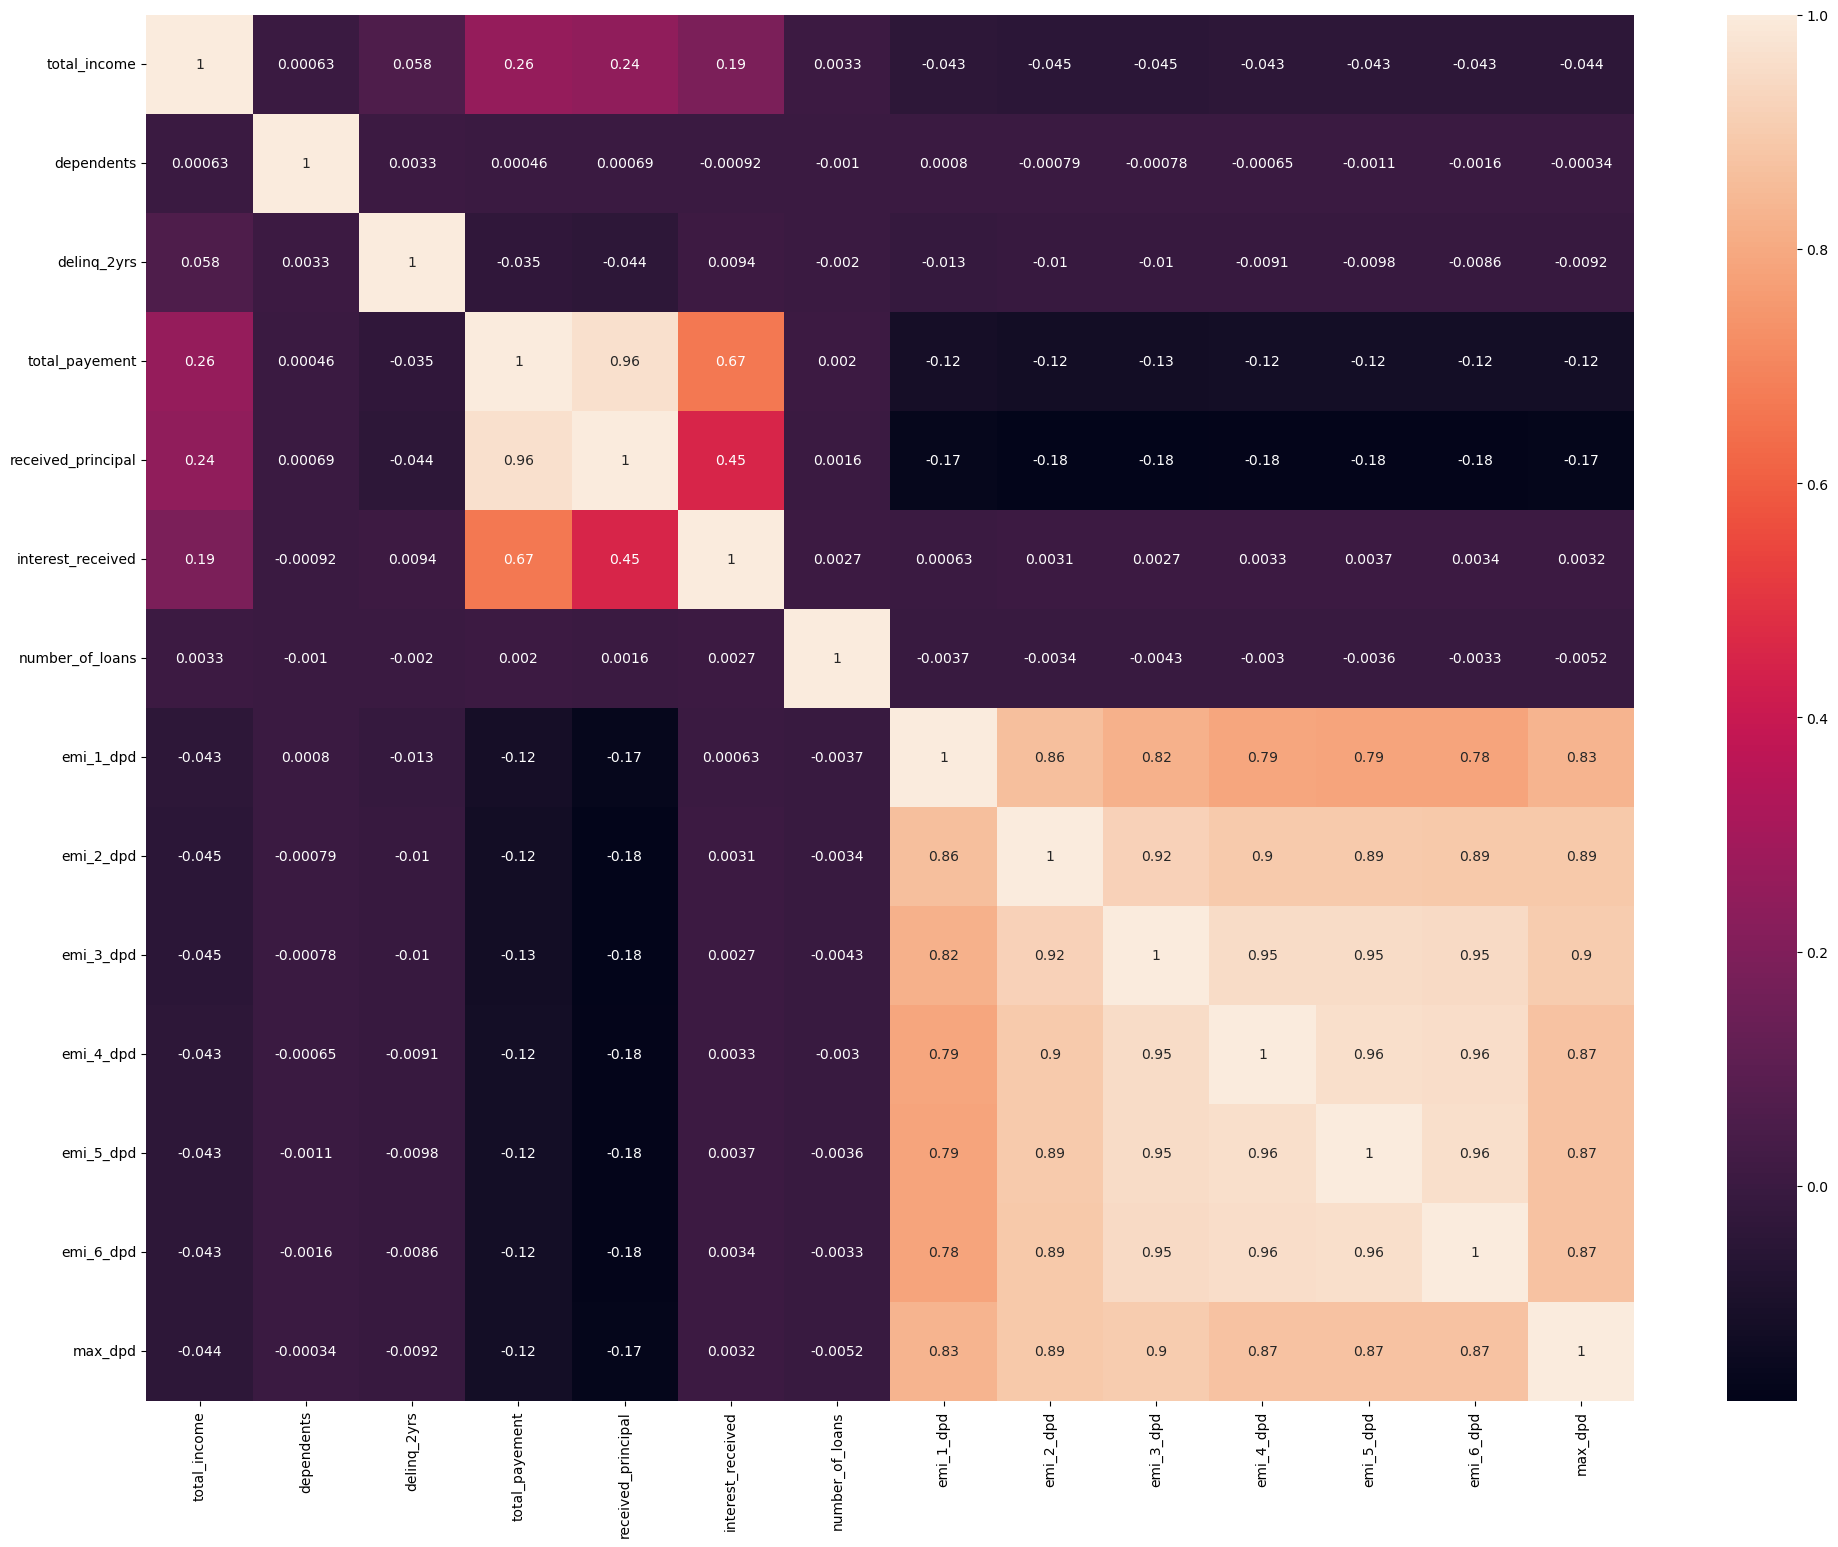

In [40]:
plt.figure(figsize = (24,18))

sns.heatmap(num_attributes.corr(method="pearson"), annot=True);

- received_principal and total_payment.
- interest_received and total_payment.
- All DPD variables.

#### Spearman Correlation Coefficient

Spearman's correlation coefficient is used to measure the monotonic correlation between variables. It is appropriate to use Spearman's correlation coefficient for nonlinear relationships.

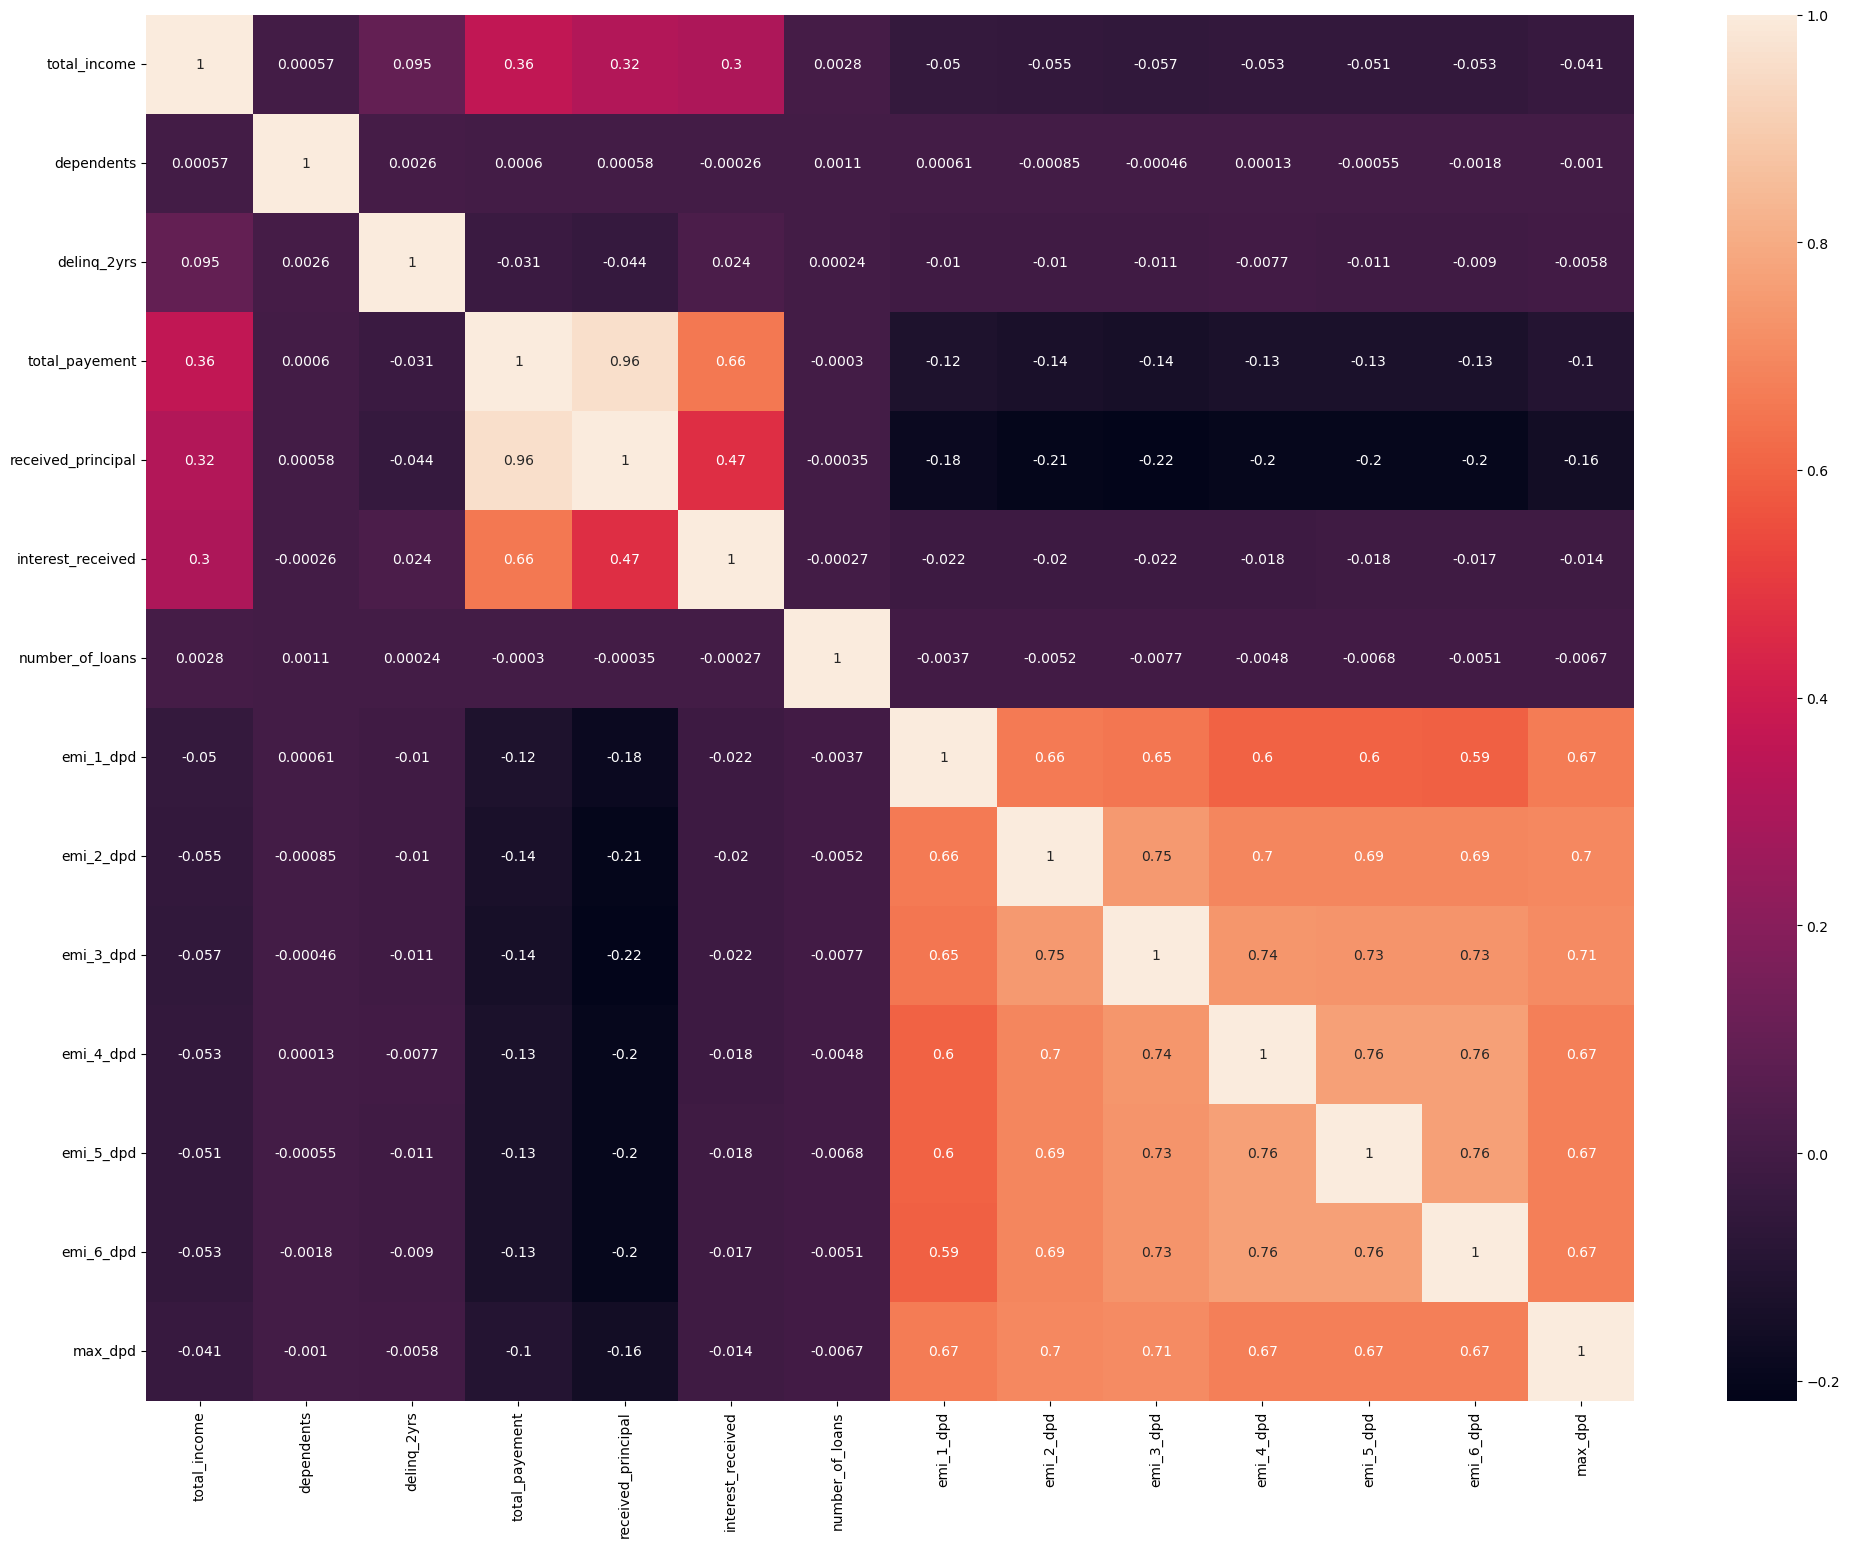

In [41]:
plt.figure(figsize = (24,18))

sns.heatmap(num_attributes.corr(method="spearman"), annot=True);

- received_principal and total_payment.
- interest_received and total_payment.
- All DPD variables.

#### Kendall Correlation Coefficient

Kendall's correlation coefficient, also known as Kendall's tau, is used to measure the strength and direction of the ordinal association between variables. It is appropriate to be used for ordinal and classified data, as well as for non-linear relationships between variables.

overflow encountered in long_scalars


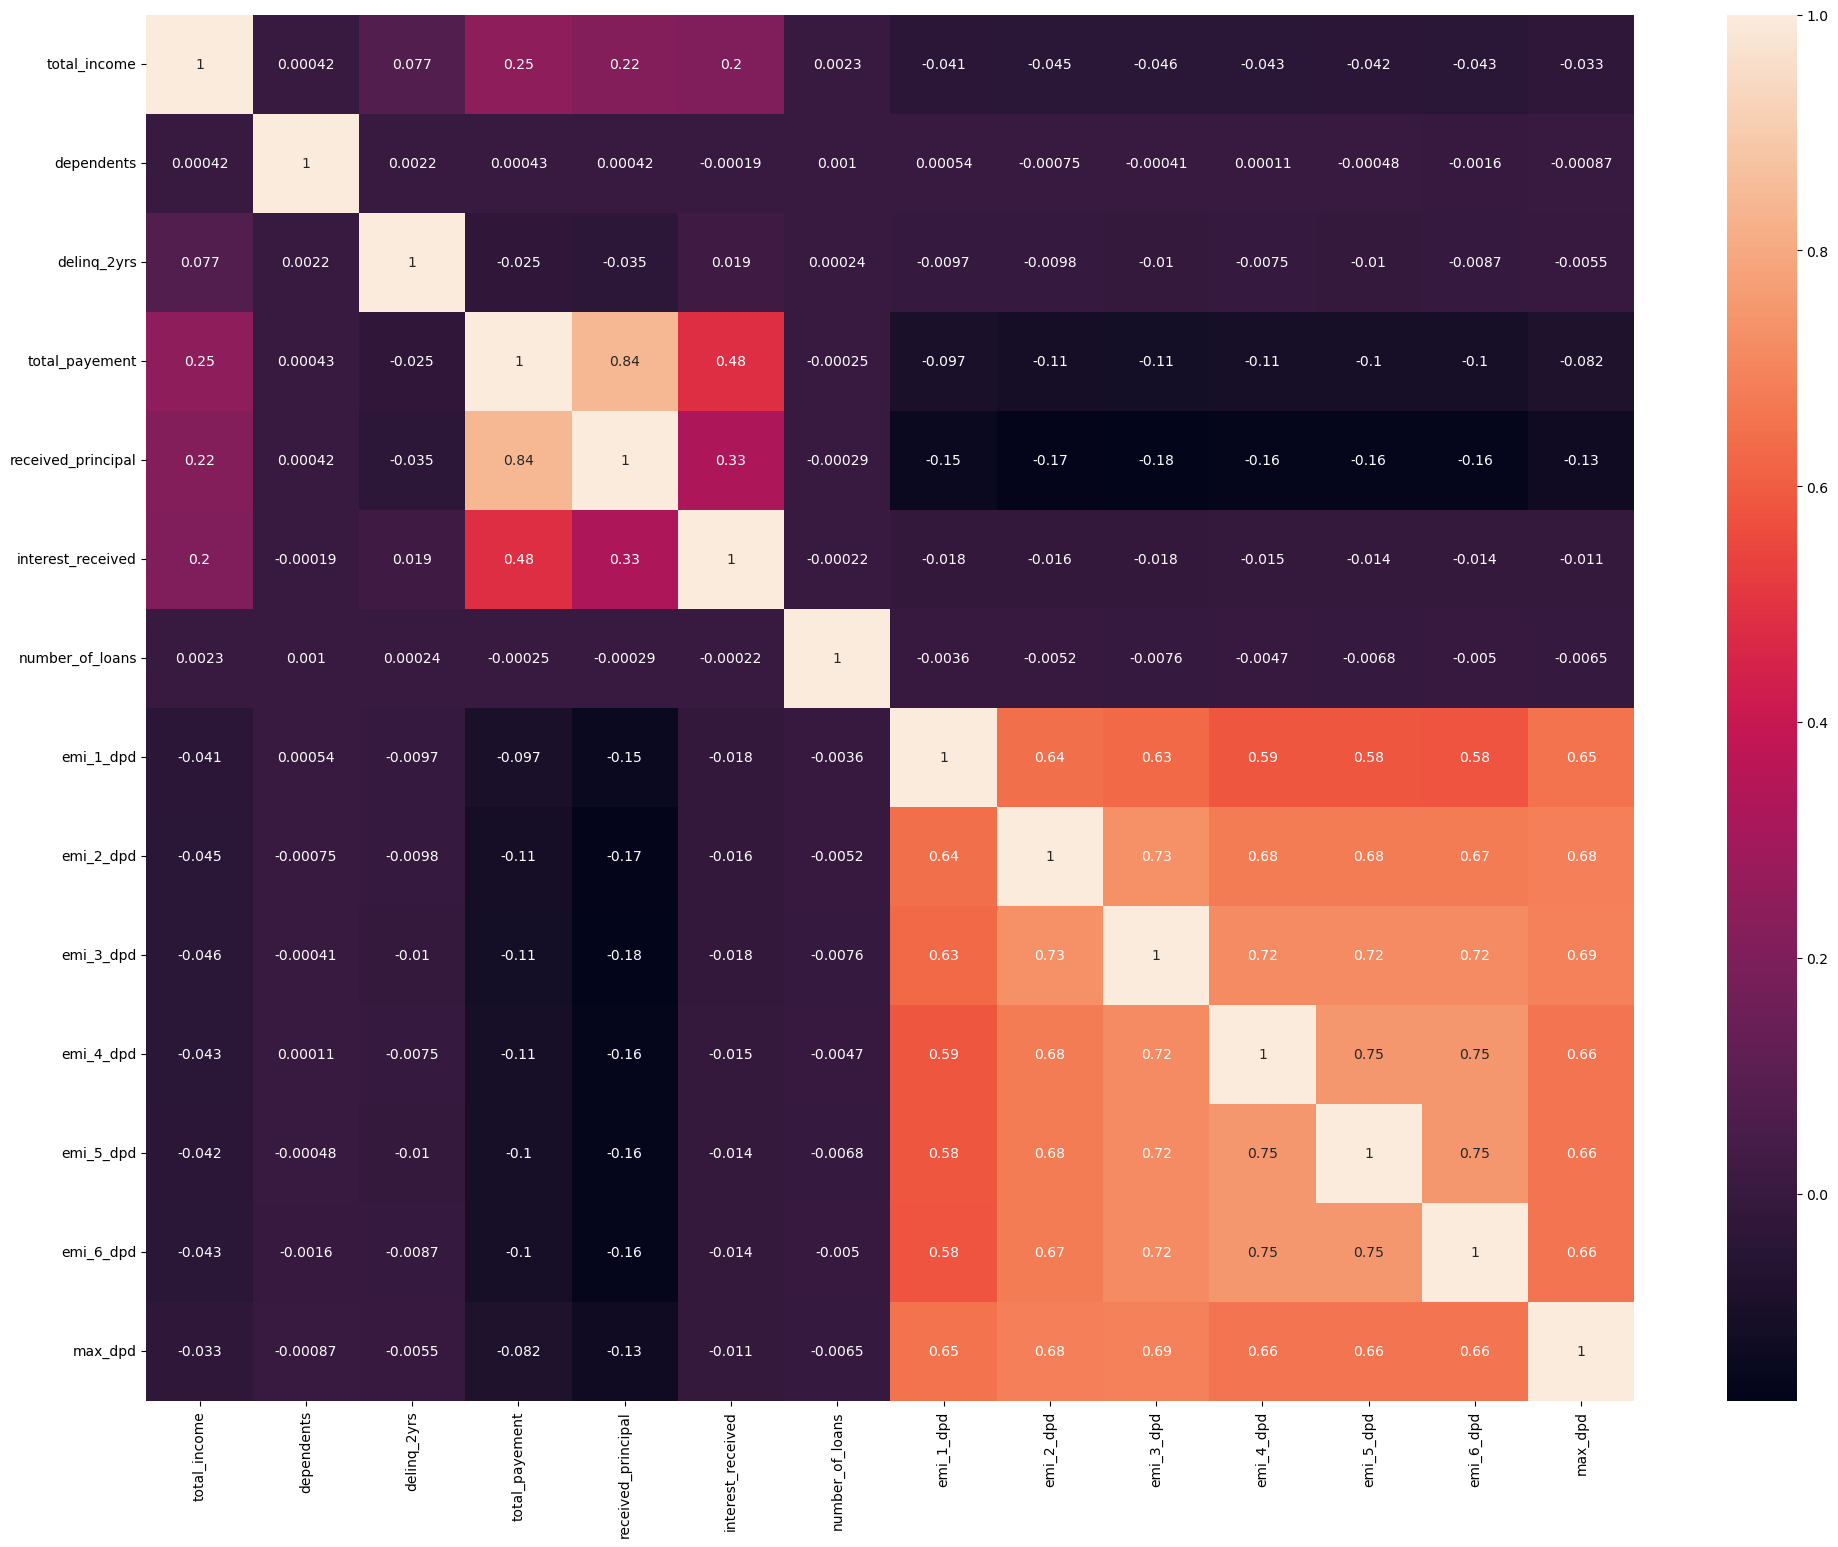

In [42]:
plt.figure(figsize = (24,18))

sns.heatmap(num_attributes.corr(method="kendall"), annot=True);

- received_principal and total_payment.
- All DPD variables

### 1.6.3. Categorical Attributes

In [43]:
cat_attributes.apply(lambda x: x.unique().shape[0])

employment_type           3
tier_of_employment        8
industry              12913
role                     46
work_experience           9
gender                    3
married                   3
home_type                 5
pincode                 844
has_social_profile        3
is_verified               4
dtype: int64

- We will apply target encoder to the variables: **industry**, **role** and **pincode**. These variables has multiple categories.

In [44]:
cat_attributes["employment_type"].unique()

array(['Salaried', 'SI', 'Self - Employeed'], dtype=object)

In [45]:
cat_attributes["tier_of_employment"].unique()

array(['E', 'SI', 'A', 'D', 'C', 'B', 'F', 'G'], dtype=object)

In [46]:
cat_attributes["industry"].unique()

array([0, '0',
       'mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIYbLnjDpXuW1BK+S9BD7Tw0=',
       ...,
       'mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhnWcLMy6BtCds+1rJfyJxydPB2ANrrLwMhyOzzBXjy1Q=',
       'mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIh1Rk8w4Ucd5yR3KcqZzLdo9gjqKV0vjoJJDvdM9yKd0Q=',
       'mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhhNsmDUtVx53lV8hFMrnPuttF3p2+esKYFxjR1R2PMpw='],
      dtype=object)

- Since the feature above is the industry of the employer, we must evaluate if it is really necessary to be used in the model.
- In the Feature Selection section we will apply feature importance to evaluate which variable we will use in the model. 

In [47]:
cat_attributes["role"].unique()

array(['KHMbckjadbckIFGNYSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGNHSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGCASEWdkcndwkcnCCM',
       'KHMbckjadbckIFGUTSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGPASEWdkcndwkcnCCM',
       'KHMbckjadbckIFGVASEWdkcndwkcnCCM',
       'KHMbckjadbckIFGNMSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGCOSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGTXSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGARSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGNCSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGMNSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGLASEWdkcndwkcnCCM',
       'KHMbckjadbckIFGTNSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGKYSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGILSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGMSSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGMISEWdkcndwkcnCCM',
       'KHMbckjadbckIFGWASEWdkcndwkcnCCM',
       'KHMbckjadbckIFGHISEWdkcndwkcnCCM',
       'KHMbckjadbckIFGORSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGWISEWdkcndwkcnCCM',
       'KHMbckjadbckIFGFLSEWdkcndwkcnCCM',
       'KHM

- I suppose we will not use this field, since it is and identification field.

In [48]:
cat_attributes["work_experience"].unique()

array([0, '0', '5-10', '<1', '1-2', '3-5', '10+', '2-3', 'SI'],
      dtype=object)

- Maybe we should apply some numeric transformation to the lebels.

In [49]:
cat_attributes["gender"].unique()

array(['Other', 'Female', 'Male'], dtype=object)

In [50]:
cat_attributes["married"].unique()

array(['SI', 'No', 'Yes'], dtype=object)

In [51]:
cat_attributes["home_type"].unique()

array(['rent', 'own', 'mortgage', 'none', 'other'], dtype=object)

In [52]:
cat_attributes["pincode"].unique()

array(['XX117X', 'XX30X', 'XX917X', 'XX325X', 'XX116X', 'XX185X',
       'XX223X', 'XX884X', 'XX805X', 'XX762X', 'XX724X', 'XX191X',
       'XX941X', 'XX286X', 'XX554X', 'XX551X', 'XX377X', 'XX104X',
       'XX928X', 'XX242X', 'XX411X', 'XX600X', 'XX122X', 'XX913X',
       'XX173X', 'XX207X', 'XX386X', 'XX926X', 'XX782X', 'XX492X',
       'XX922X', 'XX992X', 'XX967X', 'XX107X', 'XX975X', 'XX532X',
       'XX972X', 'XX328X', 'XX482X', 'XX846X', 'XX780X', 'XX38X',
       'XX347X', 'XX722X', 'XX730X', 'XX208X', 'XX175X', 'XX425X',
       'XX315X', 'XX334X', 'XX852X', 'XX919X', 'XX241X', 'XX845X',
       'XX215X', 'XX775X', 'XX894X', 'XX760X', 'XX180X', 'XX294X',
       'XX980X', 'XX493X', 'XX633X', 'XX728X', 'XX275X', 'XX467X',
       'XX718X', 'XX765X', 'XX329X', 'XX306X', 'XX752X', 'XX446X',
       'XX100X', 'XX703X', 'XX900X', 'XX970X', 'XX209X', 'XX890X',
       'XX181X', 'XX206X', 'XX902X', 'XX144X', 'XX489X', 'XX495X',
       'XX940X', 'XX945X', 'XX982X', 'XX629X', 'XX137X', 'XX394X

- It seems pincode will not be chosen by the feature importance algorithm, since it is a kind of identification column.

In [53]:
cat_attributes["has_social_profile"].unique()

array(['SI', 'No', 'Yes'], dtype=object)

In [54]:
cat_attributes["is_verified"].unique()

array(['Not Verified', 'Verified', 'Source Verified', 'SI'], dtype=object)

### 1.6.4. Correlation Matrix

In [55]:
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range( len (cat_attributes_list)):
    corr_list = []
    for j in range(len( cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramers_v(cat_attributes[ref], cat_attributes[feat])
        
        # append a list
        corr_list.append(corr)
    
    # append a correlation list for each ref attribute
    corr_dict[ref] = corr_list

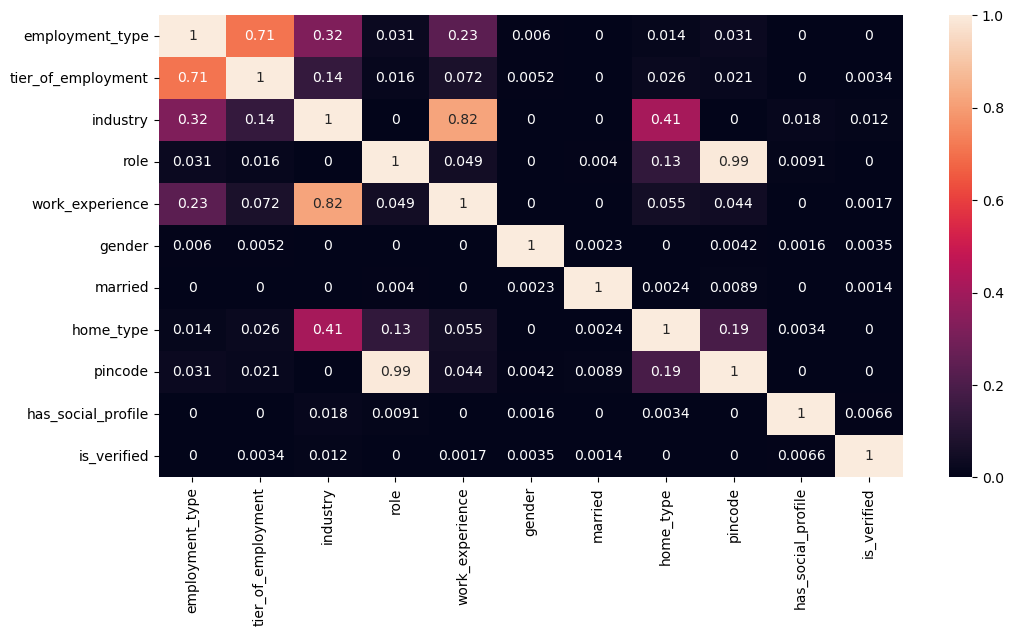

In [56]:
plt.figure(figsize =(12,6))

d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

- tier_of_employment and employment_type.
- work_experience and industry.
- pincode and role. 

### 1.6.5. Date Attributes

In [57]:
df1.dtypes

user_id                        int64
employment_type               object
tier_of_employment            object
industry                      object
role                          object
work_experience               object
total_income                 float64
gender                        object
married                       object
dependents                     int64
home_type                     object
pincode                       object
has_social_profile            object
is_verified                   object
delinq_2yrs                    int64
total_payement               float64
received_principal           float64
interest_received            float64
number_of_loans                int64
emi_1_dpd                      int64
emi_2_dpd                      int64
emi_3_dpd                      int64
emi_4_dpd                      int64
emi_5_dpd                      int64
emi_6_dpd                      int64
max_dpd                        int64
yearmo                datetime64[ns]
d

In [58]:
df1["yearmo"].unique()

array(['2022-05-01T00:00:00.000000000', '2022-04-01T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000', '2022-02-01T00:00:00.000000000',
       '2022-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

- We only have the 2022 year.
- We only have months from January to May. 

#### Training, Test and Validation Dicussion

- We must select a period for training and test: January up to April.
- The month 5 we will use for validation (back test). 

# 2. Exploratory Data Analysis (EDA)

In [59]:
df2 = df1.copy()

## 2.1. DPD Roll Rate

Firstly, let's understand the percentage of people through different DPDs (with DPD zero as basis). This rate calculates the number and percentage of people who achieved different DPDs. 

In [60]:
# % of customer achieved X dpd (Since everyone starts at 0 dpd so 100% will be at 0 dpd)
dpd_roll_rate(df2)

,dpd,user_count,user_percent
0,0,133752,100.0 %
1,30,33972,25.4 %
2,60,12139,9.08 %
3,90,11881,8.88 %


- (100 - 25.4)% customer paid back after crossing DPD 30.
- We may see that after DPD 60, the rate almost does not vary. It means DPD 60 is our cutoff (label).

## 2.2. Window Roll Rate

Then, let's understand how many people which crossed DPD 60 (cutoff above) in many EMI lifecyles. In other words, this is the percentage of people which crossed DPD 60 (60 days without pay back) for each installment.  

In [61]:
# For DPD 60 analyzing % of customer attain dpd60 on various lifecycle of EMI
window_roll_rate(df2, 60)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,first_default_emi,users_count,% of Users
0,1,9767,80.46 %
1,2,1664,13.71 %
2,3,634,5.22 %
3,4,40,0.33 %
4,5,25,0.21 %
5,6,9,0.07 %


- 80.5% of Defaulters default in 1st EMI: they took over 60 days to pay back the first installment.
- 5.2% default in 3rd EMI: they took over 60 days to pay back the third installment.
- After the third installment (number 3), tha rate almost does not vary. It means EMI 3 is our cutoff (label).

# 3. Feature Engineering

In [65]:
df3 = df2.copy()

## 3.1. Target 

The majority of defaulters cross DPD 60 in 3 months (after the third installment). Thus, we are going to considers the customers which achieved this situation as defaulters. 

In [66]:
# We will call Class 1 a defaulter
df3 = create_label(df3, dpd = 60, months = 3)

Label/target column added to dataframe!


In [67]:
df3["target"].value_counts()

0    121687
1     12065
Name: target, dtype: int64

In [68]:
df3["target"].value_counts(normalize=True)

0   0.91
1   0.09
Name: target, dtype: float64

- 9% of our entire dataset is made of defaulters.